In [1]:
import tensorflow as tf                                                                     # Importing all the required Libraries
from tensorflow import keras
from keras.models import Sequential                                                            
from keras import layers
from keras.layers import Conv2D,MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizer_v2.adam import Adam
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras import Model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np 

import cv2
import os
import shutil
import random
import glob
from PIL import Image
import fnmatch

import warnings                                                                                # Removing all those annoying Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
temp = os.listdir('/content/drive/MyDrive/UTKFace/UTKFace')                      # location of directory with images 
dataset = fnmatch.filter(temp, '*_*_*_*')                                        # format name is age_gender_ethnicity_* thus keeping only files that has perfect format   

In [3]:
random.shuffle(dataset)                                                           # Shuffeling the Images as they are in a particular order 

In [31]:
age = [i.split('_')[0] for i in dataset]                                          # Parsing thought the name of every image and taking the first element after splitting
gender = [i.split('_')[1] for i in dataset]                                       # second element dipict gender thus parsing though it and extracting gender
ethnicity = [i.split('_')[2] for i in dataset]                                    # Third element is ethnicity thus keeping it in the list

In [32]:
age = list(map(int, age))                                                         # As stored format is string converting them to interger
gender = list(map(int,gender))
ethnicity = list(map(int,ethnicity))

In [33]:
gender_classes = to_categorical(gender, num_classes=2)                           # their are two classes for gender male and female
ethnicity_classes = to_categorical(ethnicity,num_classes=5)                      # for ethnicity their are 5 Classes 

In [9]:
X_data =[]
for i in dataset:
    face = cv2.imread('/content/drive/MyDrive/UTKFace/UTKFace/'+i)               # Reading through each image so as to store the matrix in a list
    face = cv2.resize(face, (128, 128) )                                         # Assuring the size of each image to be 128X 128
    face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)                                # Converting the images to gray to keeping single channel
    X_data.append(face)                                                          # Appending the Image matrix with single channel in a list
    count+=1
    if count==1000:
      print('>', end='')
      count=0
  
X = np.squeeze(X_data)
X = X.astype('float32')
X /= 255
X_train_age,X_val_age, y_train_age, y_val_age = train_test_split(X,age, test_size=0.30)

>>>>>>>>>>>>>>>>>>>>>>>

In [11]:
X = X.astype('float32')                                    # Normalizing the values of all the pixel by dividing by 255 as it is maximimum number and dipict color white
X /= 255

In [14]:
X_train_age,X_val_age, y_train_age, y_val_age = train_test_split(X,age, test_size=0.30)
X_train_gender, X_val_gender, y_train_gender, y_val_gender = train_test_split(X,gender_classes, test_size=0.30)
X_train_ethnicity, X_val_ethnicity, y_train_ethnicity, y_val_ethnicity = train_test_split(X,ethnicity_classes, test_size=0.30)

In [15]:
len(X_train_age),len(X_val_age), len(y_train_age), len(y_val_age)

(16593, 7112, 16593, 7112)

In [16]:
cnn_model_age= Sequential([                                                       # Using Keras Sequential model to build out CNN
    Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(128,128,1)),     # First Layer of convolutional Nural network, input shape is provided only at this instance.
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),                                                   # Maxpool Layer
    Dropout(0.05),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.05),
    
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.05),

    Conv2D(256, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.1),
    
    
    Flatten(),                                                                    # Flattening out all the layers
    Dense(256, activation='relu'),
    Dropout(0.05), 

    Dense(128, activation='relu'),
    Dropout(0.05), 
    
    Dense(32, activation='relu'),
    Dense(1, activation='linear')]
)
cnn_model_age.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                    

In [7]:
# Adding various Call Backs Like Early stopping to prevent overfitting and Decay Learning Rate to prevent Overshooting

early_stopping=EarlyStopping(monitor='val_loss',
                            min_delta=0.0001,
                            patience=5,
                            verbose=2,
                            restore_best_weights=True)
decay_lr= ReduceLROnPlateau(monitor='val_loss',
                           factor=0.2,
                           patience=2,
                           verbose=1,
                           min_delta=0.001)
callbacks=[early_stopping,decay_lr]

In [18]:
X_train_age,X_val_age, y_train_age, y_val_age = np.array(X_train_age),np.array(X_val_age), np.array(y_train_age), np.array(y_val_age)

In [19]:
cnn_model_age.compile(loss='mse',optimizer='adam', metrics=['mae', 'mse'])                             # Compiling the Model, Keeping loss as Categorical Cross Entroopy and Optimizer as Adam
cnn_model_age.fit(X_train_age,y_train_age,batch_size=128,
                               epochs=40,validation_data=(X_val_age, y_val_age),
                               callbacks=callbacks, verbose=2)   

Epoch 1/40
130/130 - 26s - loss: 430.0058 - mae: 15.9347 - mse: 430.0058 - val_loss: 563.5712 - val_mae: 18.1453 - val_mse: 563.5712 - lr: 0.0010 - 26s/epoch - 197ms/step
Epoch 2/40
130/130 - 14s - loss: 337.9728 - mae: 14.1787 - mse: 337.9728 - val_loss: 244.4608 - val_mae: 12.0376 - val_mse: 244.4608 - lr: 0.0010 - 14s/epoch - 107ms/step
Epoch 3/40
130/130 - 14s - loss: 215.2121 - mae: 11.1313 - mse: 215.2121 - val_loss: 174.6313 - val_mae: 9.6204 - val_mse: 174.6313 - lr: 0.0010 - 14s/epoch - 108ms/step
Epoch 4/40
130/130 - 14s - loss: 178.8774 - mae: 9.9220 - mse: 178.8774 - val_loss: 160.0178 - val_mae: 8.9826 - val_mse: 160.0178 - lr: 0.0010 - 14s/epoch - 110ms/step
Epoch 5/40
130/130 - 14s - loss: 150.7521 - mae: 9.0773 - mse: 150.7521 - val_loss: 125.9960 - val_mae: 8.1615 - val_mse: 125.9960 - lr: 0.0010 - 14s/epoch - 111ms/step
Epoch 6/40
130/130 - 15s - loss: 128.4486 - mae: 8.3271 - mse: 128.4486 - val_loss: 112.3411 - val_mae: 7.7332 - val_mse: 112.3411 - lr: 0.0010 - 15s/

In [28]:
age_history=cnn_model_age.history.history
for i in age_history:
  print(i)

loss
mae
mse
val_loss
val_mae
val_mse
lr


In [38]:
def plot_metrics_age(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_mae = history['mae']
    val_mae = history['val_mae']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    print('\n\n')

    plt.figure()
    plt.plot(train_mae, label='Training MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.title('Loss')
    plt.legend()
    plt.show()

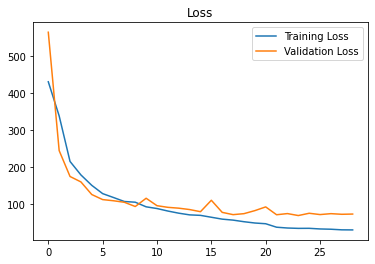

In [39]:
plot_metrics_age(age_history)

In [10]:
cnn_model_gender= Sequential([                                                       # Using Keras Sequential model to build out CNN
    Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(128,128,1)),     # First Layer of convolutional Nural network, input shape is provided only at this instance.
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),                                                   # Maxpool Layer
    Dropout(0.05),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.05),
    
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.05),

    Conv2D(256, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.1),
    
    
    Flatten(),                                                                    # Flattening out all the layers
    Dense(128, activation='relu'),
    Dropout(0.05), 
    
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')]
)
cnn_model_gender.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                    

In [12]:
cnn_model_gender.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy', 'mse'])                             # Compiling the Model, Keeping loss as Categorical Cross Entroopy and Optimizer as Adam
cnn_model_gender.fit(X_train_gender,y_train_gender,batch_size=32,
                               epochs=10,validation_data=(X_val_gender, y_val_gender),
                               callbacks=callbacks, verbose=2)   

Epoch 1/10
519/519 - 27s - loss: 0.4906 - accuracy: 0.7489 - mse: 0.1633 - val_loss: 0.3726 - val_accuracy: 0.8286 - val_mse: 0.1183 - lr: 0.0010 - 27s/epoch - 52ms/step
Epoch 2/10
519/519 - 15s - loss: 0.3451 - accuracy: 0.8475 - mse: 0.1078 - val_loss: 0.3170 - val_accuracy: 0.8550 - val_mse: 0.1002 - lr: 0.0010 - 15s/epoch - 29ms/step
Epoch 3/10
519/519 - 15s - loss: 0.3005 - accuracy: 0.8660 - mse: 0.0930 - val_loss: 0.2823 - val_accuracy: 0.8778 - val_mse: 0.0869 - lr: 0.0010 - 15s/epoch - 29ms/step
Epoch 4/10
519/519 - 15s - loss: 0.2767 - accuracy: 0.8783 - mse: 0.0846 - val_loss: 0.2616 - val_accuracy: 0.8816 - val_mse: 0.0816 - lr: 0.0010 - 15s/epoch - 29ms/step
Epoch 5/10
519/519 - 15s - loss: 0.2564 - accuracy: 0.8881 - mse: 0.0779 - val_loss: 0.2453 - val_accuracy: 0.8893 - val_mse: 0.0753 - lr: 0.0010 - 15s/epoch - 29ms/step
Epoch 6/10
519/519 - 15s - loss: 0.2423 - accuracy: 0.8937 - mse: 0.0740 - val_loss: 0.2619 - val_accuracy: 0.8832 - val_mse: 0.0815 - lr: 0.0010 - 15

In [8]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    print('\n\n')
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


In [24]:
gender_history=cnn_model_gender.history.history

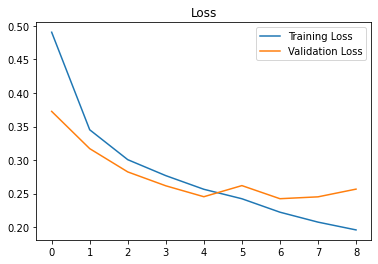

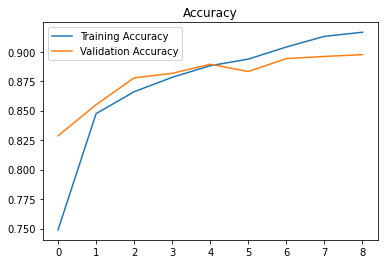

In [28]:
plot_metrics(gender_history)

In [30]:
cnn_model_ethnicity= Sequential([                                                 # Using Keras Sequential model to build out CNN
    Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(128,128,1)),     # First Layer of convolutional Nural network, input shape is provided only at this instance.
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),                                                   # Maxpool Layer
    Dropout(0.05),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.05),
    
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.05),

    Conv2D(256, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.1),
    
    
    Flatten(),                                                                    # Flattening out all the layers
    Dense(512, activation='relu'),
    Dropout(0.05), 

    Dense(128, activation='relu'),
    Dropout(0.05), 
    
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')]
)
cnn_model_ethnicity.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 126, 16)      160       
                                                                 
 conv2d_11 (Conv2D)          (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 62, 62, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                  

In [31]:
cnn_model_ethnicity.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy', 'mse'])                             # Compiling the Model, Keeping loss as Categorical Cross Entroopy and Optimizer as Adam
cnn_model_ethnicity.fit(X_train_ethnicity,y_train_ethnicity,batch_size=32,
                               epochs=10,validation_data=(X_val_ethnicity, y_val_ethnicity),
                               callbacks=callbacks, verbose=2)  

Epoch 1/10
519/519 - 17s - loss: 1.1861 - accuracy: 0.5467 - mse: 0.1192 - val_loss: 0.8997 - val_accuracy: 0.6729 - val_mse: 0.0898 - lr: 0.0010 - 17s/epoch - 33ms/step
Epoch 2/10
519/519 - 16s - loss: 0.8308 - accuracy: 0.7057 - mse: 0.0827 - val_loss: 0.7396 - val_accuracy: 0.7427 - val_mse: 0.0736 - lr: 0.0010 - 16s/epoch - 31ms/step
Epoch 3/10
519/519 - 16s - loss: 0.7266 - accuracy: 0.7434 - mse: 0.0724 - val_loss: 0.6887 - val_accuracy: 0.7560 - val_mse: 0.0686 - lr: 0.0010 - 16s/epoch - 31ms/step
Epoch 4/10
519/519 - 15s - loss: 0.6462 - accuracy: 0.7738 - mse: 0.0644 - val_loss: 0.6416 - val_accuracy: 0.7722 - val_mse: 0.0641 - lr: 0.0010 - 15s/epoch - 30ms/step
Epoch 5/10
519/519 - 16s - loss: 0.5942 - accuracy: 0.7909 - mse: 0.0595 - val_loss: 0.6482 - val_accuracy: 0.7740 - val_mse: 0.0643 - lr: 0.0010 - 16s/epoch - 30ms/step
Epoch 6/10
519/519 - 16s - loss: 0.5406 - accuracy: 0.8117 - mse: 0.0541 - val_loss: 0.6303 - val_accuracy: 0.7826 - val_mse: 0.0615 - lr: 0.0010 - 16

In [33]:
ethnicity_history=cnn_model_ethnicity.history.history

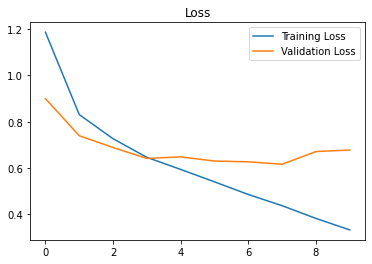

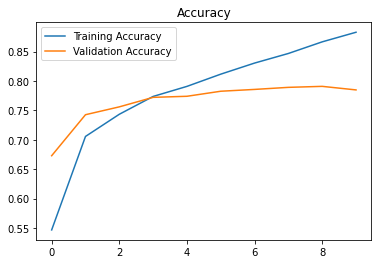

In [34]:
plot_metrics(ethnicity_history)

Applying Transfer Learning Technique using VGG16 Model

In [37]:
X_data =[]
count=0
for i in dataset[:12000]:
    face = cv2.imread('/content/drive/MyDrive/UTKFace/UTKFace/'+i)
    face = cv2.resize(face,(128, 128))
    X_data.append(face)
    count+=1
    if count==1000:
      print('>', end='')
      count=0
  
X = np.squeeze(X_data)
X = X.astype('float32')
X /= 255

>>>>>>>>>>>>

In [10]:
X_train_age,X_val_age, y_train_age, y_val_age = train_test_split(X,age[:12000], test_size=0.30)

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128,128,3))
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [17]:
vgg_model_age = Sequential([
    base_model,

    Flatten(),                                                                    # Flattening out all the layers
    Dense(512, activation='relu'),
    Dropout(0.05), 

    Dense(128, activation='relu'),
    Dropout(0.05), 
    
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

In [13]:
X_train_age,X_val_age, y_train_age, y_val_age = np.array(X_train_age),np.array(X_val_age), np.array(y_train_age), np.array(y_val_age)

In [18]:
vgg_model_age.compile(loss='mse',optimizer='adam', metrics=['mae', 'mse'])                             # Compiling the Model, Keeping loss as Categorical Cross Entroopy and Optimizer as Adam
vgg_model_age.fit(X_train_age,y_train_age,batch_size=16,
                               epochs=40,validation_data=(X_val_age, y_val_age),
                               callbacks=callbacks, verbose=2)  

Epoch 1/40
525/525 - 27s - loss: 188.1182 - mae: 10.3168 - mse: 188.1182 - val_loss: 141.6772 - val_mae: 8.6565 - val_mse: 141.6772 - lr: 0.0010 - 27s/epoch - 51ms/step
Epoch 2/40
525/525 - 25s - loss: 124.0271 - mae: 8.2771 - mse: 124.0271 - val_loss: 123.0503 - val_mae: 8.3778 - val_mse: 123.0503 - lr: 0.0010 - 25s/epoch - 47ms/step
Epoch 3/40
525/525 - 21s - loss: 107.3994 - mae: 7.6312 - mse: 107.3994 - val_loss: 110.6944 - val_mae: 7.5831 - val_mse: 110.6944 - lr: 0.0010 - 21s/epoch - 39ms/step
Epoch 4/40
525/525 - 25s - loss: 93.0989 - mae: 7.1187 - mse: 93.0989 - val_loss: 121.0522 - val_mae: 7.8419 - val_mse: 121.0522 - lr: 0.0010 - 25s/epoch - 48ms/step
Epoch 5/40

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
525/525 - 25s - loss: 84.3744 - mae: 6.7947 - mse: 84.3744 - val_loss: 123.0514 - val_mae: 8.4365 - val_mse: 123.0514 - lr: 0.0010 - 25s/epoch - 48ms/step
Epoch 6/40
525/525 - 21s - loss: 59.7019 - mae: 5.6752 - mse: 59.7019 - val_loss: 105

In [25]:
vgg_age_history= vgg_model_age.history.history
for i in vgg_age_history:
  print(i)

loss
mae
mse
val_loss
val_mae
val_mse
lr


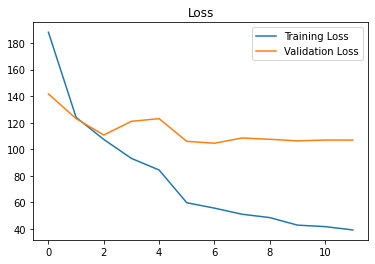

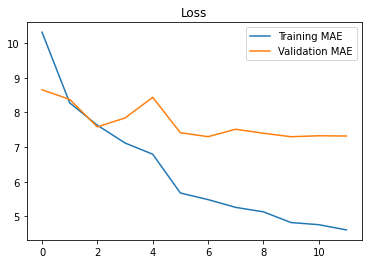

In [27]:
plot_metrics_age(vgg_age_history)

In [22]:
X_train_gender,X_val_gender, y_train_gender, y_val_gender = train_test_split(X,gender_classes[:12000], test_size=0.3)

In [35]:
vgg_model_gender = Sequential([
    base_model,

    Flatten(),                                                                    # Flattening out all the layers
    Dense(512, activation='relu'),
    Dropout(0.05), 

    Dense(128, activation='relu'),
    Dropout(0.05), 
    
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [25]:
vgg_model_gender.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy', 'mse'])                             # Compiling the Model, Keeping loss as Categorical Cross Entroopy and Optimizer as Adam
vgg_model_gender.fit(X_train_gender,y_train_gender,batch_size=16,
                               epochs=40,validation_data=(X_val_gender, y_val_gender),
                               callbacks=callbacks, verbose=2)   

Epoch 1/40
525/525 - 31s - loss: 0.4260 - accuracy: 0.8017 - mse: 0.1373 - val_loss: 0.3827 - val_accuracy: 0.8267 - val_mse: 0.1214 - lr: 0.0010 - 31s/epoch - 59ms/step
Epoch 2/40
525/525 - 21s - loss: 0.3150 - accuracy: 0.8581 - mse: 0.0980 - val_loss: 0.3173 - val_accuracy: 0.8628 - val_mse: 0.0988 - lr: 0.0010 - 21s/epoch - 40ms/step
Epoch 3/40
525/525 - 25s - loss: 0.2743 - accuracy: 0.8843 - mse: 0.0831 - val_loss: 0.5182 - val_accuracy: 0.7883 - val_mse: 0.1555 - lr: 0.0010 - 25s/epoch - 48ms/step
Epoch 4/40

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
525/525 - 25s - loss: 0.2527 - accuracy: 0.8936 - mse: 0.0769 - val_loss: 0.3325 - val_accuracy: 0.8647 - val_mse: 0.0987 - lr: 0.0010 - 25s/epoch - 48ms/step
Epoch 5/40
525/525 - 21s - loss: 0.1730 - accuracy: 0.9329 - mse: 0.0502 - val_loss: 0.3304 - val_accuracy: 0.8731 - val_mse: 0.0966 - lr: 2.0000e-04 - 21s/epoch - 40ms/step
Epoch 6/40

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.0

In [26]:
vgg_gender_history= vgg_model_gender.history.history

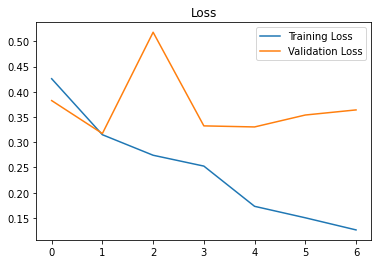

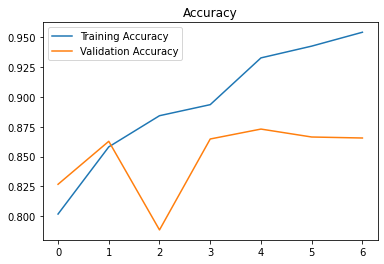

In [27]:
plot_metrics(vgg_gender_history)

In [39]:
X_train_ethnicity,X_val_ethnicity, y_train_ethnicity, y_val_ethnicity = train_test_split(X,ethnicity_classes[:12000], test_size=0.3)

In [44]:
vgg_model_ethnicity = Sequential([
    base_model,

    Flatten(),                                                                                                 # Flattening out all the layers

    Dense(128, activation='relu'),
    Dropout(0.05), 
    
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

In [45]:
vgg_model_ethnicity.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy', 'mse'])     # Compiling the Model, Keeping loss as Categorical Cross Entroopy and Optimizer as Adam
vgg_model_ethnicity.fit(X_train_ethnicity,y_train_ethnicity,batch_size=16,
                               epochs=10,validation_data=(X_val_ethnicity, y_val_ethnicity),
                               callbacks=callbacks, verbose=2)  

Epoch 1/10
525/525 - 27s - loss: 1.0988 - accuracy: 0.5879 - mse: 0.1102 - val_loss: 1.0205 - val_accuracy: 0.6158 - val_mse: 0.1029 - lr: 0.0010 - 27s/epoch - 51ms/step
Epoch 2/10
525/525 - 25s - loss: 0.8574 - accuracy: 0.6905 - mse: 0.0866 - val_loss: 0.9438 - val_accuracy: 0.6547 - val_mse: 0.0943 - lr: 0.0010 - 25s/epoch - 47ms/step
Epoch 3/10
525/525 - 25s - loss: 0.7544 - accuracy: 0.7265 - mse: 0.0762 - val_loss: 0.9127 - val_accuracy: 0.6644 - val_mse: 0.0918 - lr: 0.0010 - 25s/epoch - 47ms/step
Epoch 4/10
525/525 - 21s - loss: 0.6587 - accuracy: 0.7604 - mse: 0.0672 - val_loss: 0.8835 - val_accuracy: 0.7008 - val_mse: 0.0859 - lr: 0.0010 - 21s/epoch - 40ms/step
Epoch 5/10
525/525 - 25s - loss: 0.5831 - accuracy: 0.7915 - mse: 0.0595 - val_loss: 1.0200 - val_accuracy: 0.6606 - val_mse: 0.0974 - lr: 0.0010 - 25s/epoch - 47ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
525/525 - 25s - loss: 0.5410 - accuracy: 0.8036 - mse: 0.0556

In [46]:
vgg_ethnicity_history= vgg_model_ethnicity.history.history

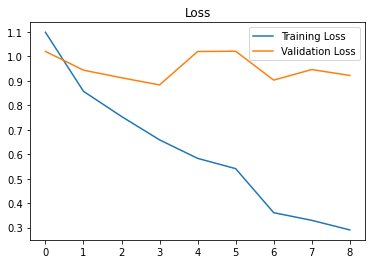

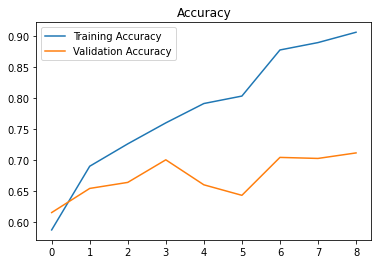

In [47]:
plot_metrics(vgg_ethnicity_history)